<a href="https://colab.research.google.com/github/isaaccorley/torchgeo/blob/transforms%2Findices/docs/tutorials/indices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Indices

In this tutorial, we demonstrate how to use TorchGeo's functions and transforms for computing popular indices used in remote sensing and provide examples of how to utilize them in your experiments or simply for visualization. Some common indices and their formulas can be found at the following links:

- [Index Database](https://www.indexdatabase.de/db/i.php)
- [Awesome Spectral Indices](https://github.com/davemlz/awesome-spectral-indices)

It's recommended to run this notebook on Google Colab if you don't have your own GPU. Click the "Open in Colab" button above to get started.

## Setup

Install TorchGeo

In [ ]:
%pip install 'git+https://github.com/isaaccorley/torchgeo.git@transforms/indices'

Install additional libraries

In [2]:
%pip install tifffile

     |████████████████████████████████| 171 kB 1.9 MB/s 
Note: you may need to restart the kernel to use updated packages.


Download the EuroSat Multispectral (MS) Sentinel-2 dataset (~2.8GB)

In [5]:
from torchgeo.datasets.utils import download_and_extract_archive

import os
os.makedirs("eurosat", exist_ok=True)
download_and_extract_archive(
    url="http://madm.dfki.de/files/sentinel/EuroSATallBands.zip",
    download_root=".",
    extract_root="eurosat"
)

  0%|          | 0/2067725275 [00:00<?, ?it/s]

## Imports

In [5]:
import os
from typing import List

import torch
import numpy as np
import torch.nn as nn
import tifffile
import kornia.augmentation as K
import torchvision.transforms as T
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from torchgeo.transforms import indices
from torchgeo.transforms import AugmentationSequential

## Custom Image Transforms

- `MinMaxNormalize` normalizes the band values to a common range between [0, 1].
- `ToTensor` converts the images from numpy arrays to torch Tensors and swaps the channel dimension from `HWC` to `CHW`.

In [6]:
class MinMaxNormalize(nn.Module):
  """ Normalize channels to the range [0, 1] using min/max values """
  def __init__(self, min: List[float], max: List[float]):
    super().__init__()
    self.min = torch.tensor(min)[:, None, None]
    self.max = torch.tensor(max)[:, None, None]
    self.denominator = (self.max - self.min)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = (x - self.min) / self.denominator
    x = x.clip(0, 1)
    return x

class ToTensor(nn.Module):
  def forward(self, x: np.ndarray) -> torch.Tensor:
    x = x.astype(np.float32)
    x = torch.from_numpy(x)
    x = x.permute((2, 0, 1))
    return x

## Dataset Bands and Statistics

In [7]:
mins = [1013.0, 676.0, 448.0, 247.0, 269.0, 253.0, 243.0, 189.0, 61.0, 4.0, 33.0, 11.0, 186.0]
maxs = [2309.0, 4543.05, 4720.2, 5293.05, 3902.05, 4473.0, 5447.0, 5948.05, 1829.0, 23.0, 4894.05, 4076.05, 5846.0]
bands = {
  "B1": "Coastal Aerosol",
  "B2": "Blue",
  "B3": "Green",
  "B4": "Red",
  "B5": "Vegetation Red Edge 1",
  "B6": "Vegetation Red Edge 2",
  "B7": "Vegetation Red Edge 3",
  "B8": "NIR 1",
  "B8A": "NIR 2",
  "B9": "Water Vapour",
  "B10": "SWIR 1",
  "B11": "SWIR 2",
  "B12": "SWIR 3"
}

## Load the EuroSat MS dataset and dataloader

Here we load the EuroSat Multispectral (MS) dataset. The dataset contains  27,000 64x64 Sentinel-2 multispectral patches with 10 land cover classes.

In [8]:
root = "eurosat"
root = os.path.join(root, "ds/images/remote_sensing/otherDatasets/sentinel_2/tif")
transform = T.Compose([ToTensor(), MinMaxNormalize(mins, maxs)])
dataset = ImageFolder(
  root=root,
  transform=transform,
  loader=tifffile.imread
)
dataloader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    num_workers=2
)
dataloader = iter(dataloader)
print(f"Number of images in dataset: {len(dataset)}")
print(f"Dataset Classes: {dataset.classes}")

Number of images in dataset: 27000
Dataset Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


## Load a sample image and class label

Here we test our dataset by loading a single image and label. Note how the image is of shape (13, 64, 64) containing a 64x64 shape with 13 multispectral bands.

In [9]:
x, y = dataset[0]
print(x.shape, x.dtype, x.min(), x.max())
print(y, dataset.classes[y])

torch.Size([13, 64, 64]) torch.float32 tensor(0.0843) tensor(0.7112)
0 AnnualCrop


In [ ]:
# This cell aggregates min/max band statistics for the dataset
# Outlier values are ignored by computing the 5/95 percentile of the per band min and max, respectively.
from tqdm import tqdm

mins, maxs = [], []
for i in tqdm(range(len(dataset)), position=0, leave=False):
  x, _ = dataset[i]
  x = x.reshape(-1, 13)
  mins.append(x.min(axis=0))
  maxs.append(x.max(axis=0))

mins, maxs = np.stack(mins), np.stack(maxs)
dra_mins = [np.percentile(mins[:, i], 5) for i in range(mins.shape[-1])]
dra_maxs = dra_maxs = [np.percentile(maxs[:, i], 95) for i in range(maxs.shape[-1])]
print(dra_mins)
print(dra_maxs)

## Indices Usage

Indices can be computed easily using the functional interfaces.

In [10]:
index = indices.ndvi(red=x[3], nir=x[7])
print(index.shape, index.min(), index.max())

torch.Size([64, 64]) tensor(0.0618) tensor(0.5265)


Indices can also be computed on batches of images and appended as an additional band to the specified channel dimension. Notice how the number of channels increased from 13 -> 14.

In [11]:
transform = indices.AppendNDVI(index_red=3, index_nir=7, dim=1)
x, y = next(dataloader)
batch = {"image": x, "label": y}
print(batch["image"].shape)
batch = transform(batch)
print(batch["image"].shape)

torch.Size([4, 13, 64, 64])
torch.Size([4, 14, 64, 64])


This makes it incredibly easy to add indices as additional features during training by chaining multiple Appends together.

In [12]:
transforms = nn.Sequential(
  indices.AppendNDBI(index_swir=11, index_nir=7),
  indices.AppendNDSI(index_green=3, index_swir=11),
  indices.AppendNDVI(index_red=3, index_nir=7),
  indices.AppendNDWI(index_green=2, index_nir=7),
)

x, y = next(dataloader)
batch = {"image": x, "label": y}
print(batch["image"].shape)
batch = transforms(batch)
print(batch["image"].shape)

torch.Size([4, 13, 64, 64])
torch.Size([4, 17, 64, 64])


It's even possible to chain indices along with augmentations from kornia for a single callable during training

In [129]:
augmentations = AugmentationSequential(
  K.RandomHorizontalFlip(p=0.5),
  K.RandomVerticalFlip(p=0.5),
  data_keys=["image"],
)
transforms = nn.Sequential(
  indices.AppendNDBI(index_swir=11, index_nir=7),
  indices.AppendNDSI(index_green=3, index_swir=11),
  indices.AppendNDVI(index_red=3, index_nir=7),
  indices.AppendNDWI(index_green=2, index_nir=7),
  augmentations
)

x, y = next(dataloader)
batch = {"image": x, "label": y, "mask": torch.randn(4, 1, 64, 64)}
print(batch["image"].shape)
batch = transforms(batch)
print(batch["image"].shape)



torch.Size([4, 13, 64, 64])
torch.Size([4, 17, 64, 64])


## Visualize Images and Labels

Class Label: SeaLake


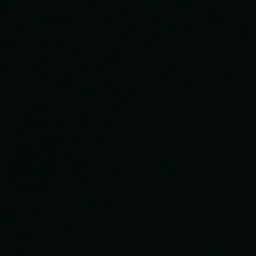

In [23]:
#@title EuroSat Multispectral (MS) Browser  { run: "auto", vertical-output: true }
idx = 25644 #@param {type:"slider", min:0, max:26999, step:1}
x, y = dataset[idx]
rgb = x[1:4]
rgb = rgb[[2, 1, 0], ...]
image = T.ToPILImage()(rgb)
print(f"Class Label: {dataset.classes[y]}")
image.resize((256, 256), resample=Image.BILINEAR)